#Task II: Classical Graph Neural Network (GNN)
For Task II, you will use ParticleNet’s data for Quark/Gluon jet classification available here with its corresponding description.

- Choose 2 Graph-based architectures of your choice to classify jets as being quarks or gluons. Provide a description on what considerations you have taken to project this point-cloud dataset to a set of interconnected nodes and edges.
- Discuss the resulting performance of the 2 chosen architectures.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
import logging
logging.basicConfig(level=logging.INFO, format='[%(asctime)s] %(levelname)s: %(message)s')

In [ ]:
!wget https://zenodo.org/records/3164691/files/QG_jets.npz -P /content/data/
!wget https://raw.githubusercontent.com/hqucms/ParticleNet/master/tf-keras/tf_keras_model.py

--2024-04-02 07:57:02--  https://zenodo.org/records/3164691/files/QG_jets.npz
Resolving zenodo.org (zenodo.org)... 188.185.79.172, 188.184.103.159, 188.184.98.238, ...
Connecting to zenodo.org (zenodo.org)|188.185.79.172|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106689379 (102M) [application/octet-stream]
Saving to: ‘/content/data/QG_jets.npz’

QG_jets.npz         100%[===================>] 101.75M  1.38MB/s    in 81s     

2024-04-02 07:58:25 (1.25 MB/s) - ‘/content/data/QG_jets.npz’ saved [106689379/106689379]

--2024-04-02 07:58:25--  https://raw.githubusercontent.com/hqucms/ParticleNet/master/tf-keras/tf_keras_model.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7583 (7.4K) [text/plain]
Saving to: ‘tf_keras_model.py’



# Data

The dataset used in this project was actually used in P. T. Komiske, E. M. Metodiev, J. Thaler, Energy Flow Networks: Deep Sets for Particle Jets, JHEP 01 (2019) 121, arXiv:1810.05165[1].
It has 20 files consisting of jet data with each file having 100k samples.There are two arrays in each file

- X: (100000,M,4), exactly 50k quark and 50k gluon jets, randomly sorted, where M is the max multiplicity of the jets in that file (other jets have been padded with zero-particles), and the features of each particle are its pt, rapidity, azimuthal angle, and pdgid.
- y: (100000,), an array of labels for the jets where gluon is 0 and quark is 1.

# Chosen Architecture

1. ParticleNet Lite (Dynamic)

  ParticleNet Lite consists of three EdgeConv blocks with hyperparameter-values less than that are used in ParticleNet.The first EdgeConv block uses the spatial coordinates of the particles in the pseudorapidity-azimuth space to compute the distances, while the subsequent blocks use the learned feature vectors as coordinates.

2. ParticleNet Lite (Static)
  
  This architecture is exactly the same as the dynamic ParticleNet Lite except the fact that there is no dynamic update of the co-ordinates of particles based on the learned feature vectors, i.e the co-ordinates are always in the pseudorapidity-azimuth space to compute the distances between them.

Both networks use a global average pooling for aggregating over the values obtained from the EdgeConv blocks along with a fully connected network with 2 units and output layer with a softmax function.

- ParticleNet and ParticleNet Lite have fundamentally similar architectures that use the power of EdgeConv to parameterize over local dependencies in the point-cloud representation and give better results that most other approaches.

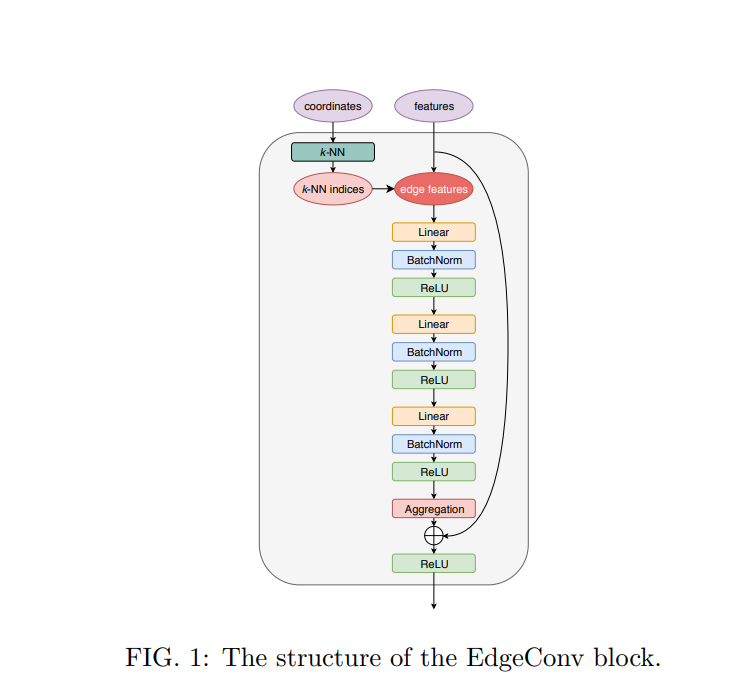

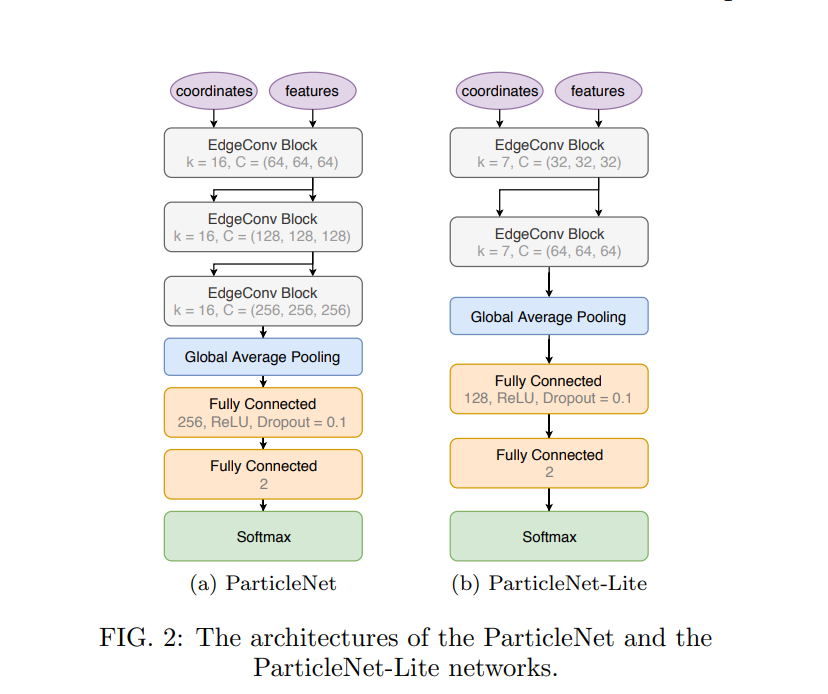

# Preprocessing

In [ ]:
from tf_keras_model import get_particle_net, get_particle_net_lite
from tf_keras_model_static import get_particle_net_static, get_particle_net_lite_static

In [ ]:
def data_preprocess(data_1,data_2,label_1,label_2):
    if(data_1.shape[1] != data_2.shape[1]):
        if(data_1.shape[1]>data_2.shape[1]):
            data_2=np.concatenate((data_2,np.zeros((data_2.shape[0],data_1.shape[1]-data_2.shape[1],data_2.shape[2]))),axis=1)
        if(data_2.shape[1]>data_1.shape[1]):
            data_1=np.concatenate((data_1,np.zeros((data_1.shape[0],data_2.shape[1]-data_1.shape[1],data_1.shape[2]))) ,axis=1)

    dataset_X = np.concatenate((data_1,data_2), axis=0)
    dataset_y = np.concatenate((label_1,label_2), axis=0)

    return dataset_X,dataset_y

In [ ]:
data = np.load('./data/QG_jets.npz',allow_pickle=True)
X_train = data['X']
y_train = data['y']

#Transform the labels to one-hot format
y_train = tf.keras.utils.to_categorical(y_train)

In [9]:
# sanity check
print(X_train.shape)
print(y_train.shape)

(100000, 139, 4)
(100000, 2)


 Splitting the dataset into three parts- 80% training data, 10% validation data, 10% test data

In [10]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

X_train,y_train = shuffle(X_train, y_train, random_state=1024)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=1024)
X_val,X_test,y_val,y_test= train_test_split(X_val,y_val,test_size=0.5,random_state=1024)

num_particles = X_train.shape[1]
#check
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)

(80000, 139, 4)
(10000, 139, 4)
(10000, 139, 4)
(80000, 2)


1. points contain rapidity, azimuthal angle used for computing the distance of KNN

2. features: the features of the particles. pt, rapidity, azimuthal angle.

3. mask gives information whether the particle is a real particle from the dataset or just a padded "zero-particles" mask array taking a value of 0 for padded positions.

In [11]:
train_dict = {
    'points' : X_train[:,:,1:3],
    'features' : X_train,
    'mask': np.sum(X_train, axis=2).reshape(len(X_train), num_particles, 1)
    }

val_dict = {
    'points' : X_val[:,:,1:3],
    'features' : X_val,
    'mask': np.sum(X_val, axis=2).reshape(len(X_val), num_particles, 1)
    }

test_dict = {
    'points' : X_test[:,:,1:3],
    'features' : X_test,
    'mask': np.sum(X_test, axis=2).reshape(len(X_test), num_particles, 1)
    }

# Init Model

In [12]:
num_classes = 2
input_shapes = {k:train_dict[k].shape[1:] for k in train_dict}
print(input_shapes)

{'points': (139, 2), 'features': (139, 4), 'mask': (139, 1)}


In [19]:
model_lite_dynamic = get_particle_net_lite(num_classes,input_shapes)
model_lite_static = get_particle_net_lite_static(num_classes,input_shapes)

In [17]:
# parameters
batch_size = 300
batch_size_lite = 1200

epochs = 20

In [18]:
# learning rate schedule
def lr_schedule(epochs):
    learning_rate = 0.001
    if epochs>9:
        learning_rate*=0.1
    if epochs>18:
        learning_rate*=0.01
    logging.info('Learning rate: %f'%learning_rate)
    return learning_rate

In [20]:
model_lite_dynamic.compile(loss = 'categorical_crossentropy',
             optimizer=keras.optimizers.Adam(learning_rate=lr_schedule(0)),
             metrics=['accuracy',tf.keras.metrics.AUC()])
model_lite_dynamic.summary()

Model: "ParticleNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 mask (InputLayer)           [(None, 139, 1)]             0         []                            
                                                                                                  
 tf.math.not_equal_4 (TFOpL  (None, 139, 1)               0         ['mask[0][0]']                
 ambda)                                                                                           
                                                                                                  
 tf.cast_8 (TFOpLambda)      (None, 139, 1)               0         ['tf.math.not_equal_4[0][0]'] 
                                                                                                  
 tf.math.equal_4 (TFOpLambd  (None, 139, 1)               0         ['tf.cast_8[0][0]'] 

In [21]:
lr_scheduler=keras.callbacks.LearningRateScheduler(lr_schedule)
progress_bar = keras.callbacks.ProgbarLogger()
callbacks=[lr_scheduler,progress_bar]

print(train_dict['points'].shape)
print(train_dict['features'].shape)
print(train_dict['mask'].shape)

(80000, 139, 2)
(80000, 139, 4)
(80000, 139, 1)


# Train Model

In [22]:
history_dynamic = model_lite_dynamic.fit(train_dict,
                   y_train,
                   epochs=epochs,
                   batch_size=batch_size,
                   validation_data=(val_dict,y_val),
                   callbacks=callbacks,
                   shuffle=True)

Epoch 1/20
267/267 [==============================] - 854s 3s/sample - loss: 0.4964 - accuracy: 0.7638 - auc: 0.8400 - val_loss: 0.4949 - val_accuracy: 0.7666 - val_auc: 0.8418 - lr: 0.0010
Epoch 2/20
267/267 [==============================] - 798s 3s/sample - loss: 0.4701 - accuracy: 0.7829 - auc: 0.8585 - val_loss: 0.4729 - val_accuracy: 0.7809 - val_auc: 0.8570 - lr: 0.0010
Epoch 3/20
267/267 [==============================] - 760s 3s/sample - loss: 0.4603 - accuracy: 0.7908 - auc: 0.8650 - val_loss: 0.4726 - val_accuracy: 0.7885 - val_auc: 0.8589 - lr: 0.0010
Epoch 4/20
267/267 [==============================] - 750s 3s/sample - loss: 0.4537 - accuracy: 0.7956 - auc: 0.8693 - val_loss: 0.4472 - val_accuracy: 0.7980 - val_auc: 0.8736 - lr: 0.0010
Epoch 5/20
267/267 [==============================] - 753s 3s/sample - loss: 0.4478 - accuracy: 0.7994 - auc: 0.8731 - val_loss: 0.4498 - val_accuracy: 0.7998 - val_auc: 0.8736 - lr: 0.0010
Epoch 6/20
267/267 [==============================

# Plot AUC Dynamic

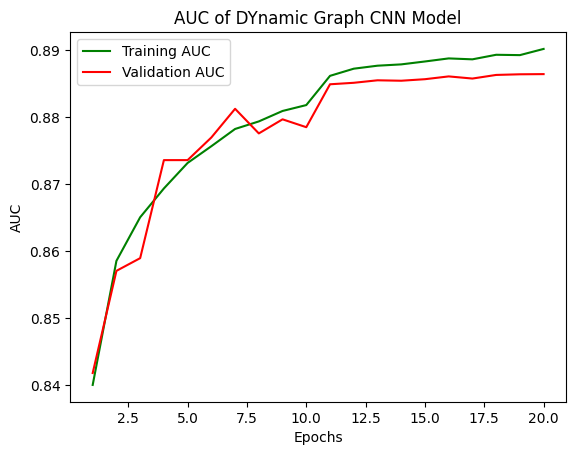

In [25]:
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history_dynamic.history['auc'], color='green', label='Training AUC')
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history_dynamic.history['val_auc'], color='red', label='Validation AUC')
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.title("AUC of DYnamic Graph CNN Model")
plt.legend()
plt.show()

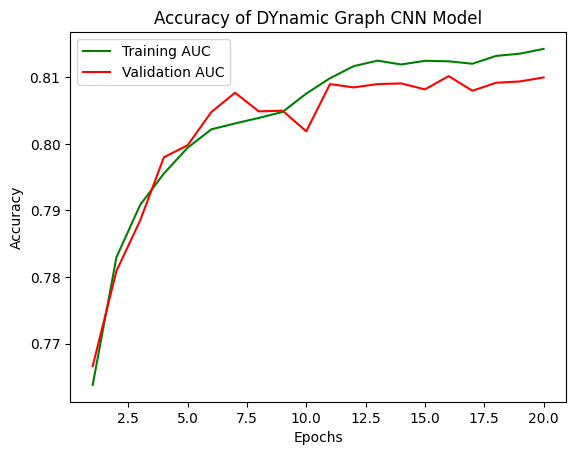

In [26]:
# Accuracy
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history_dynamic.history['accuracy'], color='green', label='Training AUC')
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history_dynamic.history['val_accuracy'], color='red', label='Validation AUC')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy of DYnamic Graph CNN Model")
plt.legend()
plt.show()

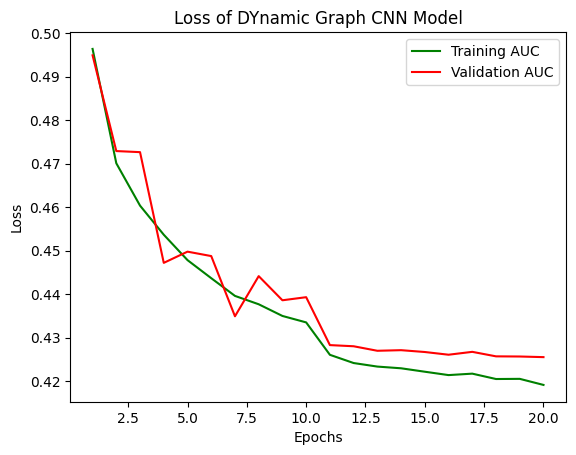

In [27]:
# loss
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history_dynamic.history['loss'], color='green', label='Training AUC')
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history_dynamic.history['val_loss'], color='red', label='Validation AUC')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss of DYnamic Graph CNN Model")
plt.legend()
plt.show()

# Evaluate

In [28]:
loss, acc, auc = model_lite_dynamic.evaluate(test_dict, y_test)
print("Evaluation Metric of DYnamic Graph CNN Model on Test Dataset")
print("Accuracy:", acc)
print("Loss:", loss)
print("AUC:", auc)

313/313 [==============================] - 16s 51ms/step - loss: 0.4270 - accuracy: 0.8086 - auc: 0.8854
Evaluation Metric of DYnamic Graph CNN Model on Test Dataset
Accuracy: 0.8086000084877014
Loss: 0.42700058221817017
AUC: 0.8853965997695923


# Static ParticleNet
Note: no changes made in hyperparameters

In [29]:
model_lite_static.compile(loss = 'categorical_crossentropy',
             optimizer=keras.optimizers.Adam(learning_rate=lr_schedule(0)),
             metrics=['accuracy',tf.keras.metrics.AUC()])
model_lite_static.summary()

Model: "ParticleNet_Lite_Static"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 mask (InputLayer)           [(None, 139, 1)]             0         []                            
                                                                                                  
 tf.math.not_equal_5 (TFOpL  (None, 139, 1)               0         ['mask[0][0]']                
 ambda)                                                                                           
                                                                                                  
 tf.cast_10 (TFOpLambda)     (None, 139, 1)               0         ['tf.math.not_equal_5[0][0]'] 
                                                                                                  
 tf.math.equal_5 (TFOpLambd  (None, 139, 1)               0         ['tf.cas

In [30]:
lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
progress_bar = keras.callbacks.ProgbarLogger()
callbacks = [lr_scheduler,progress_bar]

print(train_dict['points'].shape)
print(train_dict['features'].shape)
print(train_dict['mask'].shape)

(80000, 139, 2)
(80000, 139, 4)
(80000, 139, 1)


# Train Model

In [31]:
history_static = model_lite_static.fit(train_dict,
                   y_train,
                   epochs=epochs,
                   batch_size=batch_size,
                   callbacks=callbacks,
                   validation_data=(val_dict,y_val),
                   shuffle=True)

Epoch 1/20
267/267 [==============================] - 737s 3s/sample - loss: 0.4929 - accuracy: 0.7695 - auc_1: 0.8434 - val_loss: 0.5229 - val_accuracy: 0.7397 - val_auc_1: 0.8172 - lr: 0.0010
Epoch 2/20
267/267 [==============================] - 727s 3s/sample - loss: 0.4578 - accuracy: 0.7957 - auc_1: 0.8671 - val_loss: 0.4644 - val_accuracy: 0.7910 - val_auc_1: 0.8667 - lr: 0.0010
Epoch 3/20
267/267 [==============================] - 721s 3s/sample - loss: 0.4466 - accuracy: 0.8019 - auc_1: 0.8738 - val_loss: 0.4435 - val_accuracy: 0.8011 - val_auc_1: 0.8766 - lr: 0.0010
Epoch 4/20
267/267 [==============================] - 719s 3s/sample - loss: 0.4405 - accuracy: 0.8048 - auc_1: 0.8774 - val_loss: 0.4553 - val_accuracy: 0.7963 - val_auc_1: 0.8706 - lr: 0.0010
Epoch 5/20
267/267 [==============================] - 726s 3s/sample - loss: 0.4374 - accuracy: 0.8052 - auc_1: 0.8794 - val_loss: 0.4391 - val_accuracy: 0.8015 - val_auc_1: 0.8786 - lr: 0.0010
Epoch 6/20
267/267 [==========

# Plot AUC Static

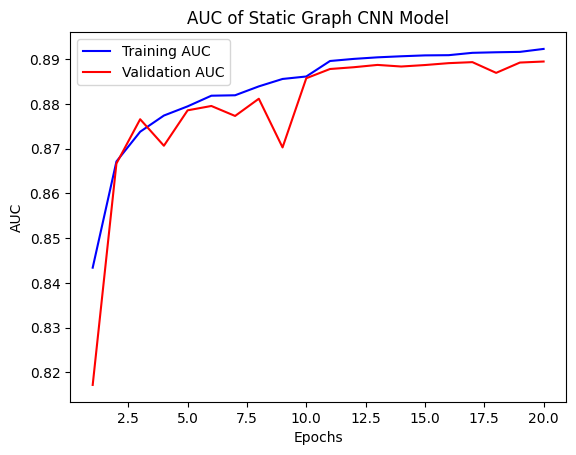

In [32]:
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history_static.history['auc_1'], color='blue', label='Training AUC')
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history_static.history['val_auc_1'], color='red', label='Validation AUC')
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.title("AUC of Static Graph CNN Model")
plt.legend()
plt.show()

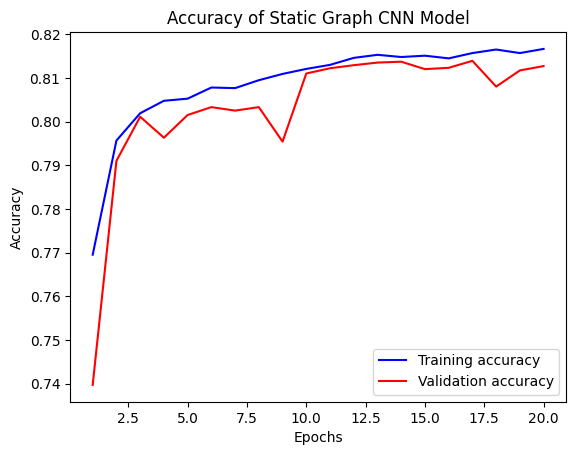

In [37]:
# accuracy
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history_static.history['accuracy'], color='blue', label='Training accuracy')
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history_static.history['val_accuracy'], color='red', label='Validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy of Static Graph CNN Model")
plt.legend()
plt.show()

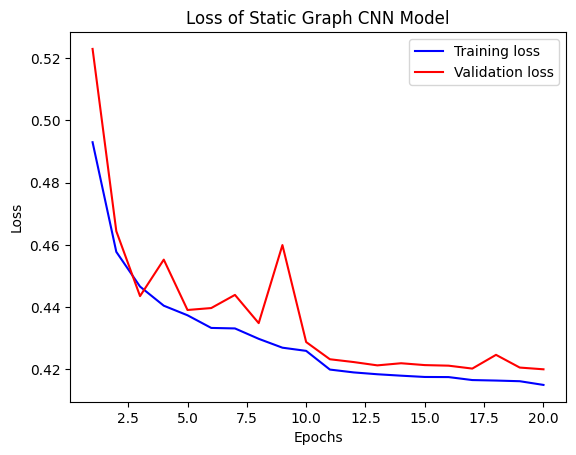

In [38]:
# loss
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history_static.history['loss'], color='blue', label='Training loss')
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history_static.history['val_loss'], color='red', label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss of Static Graph CNN Model")
plt.legend()
plt.show()

# Evaluate

In [35]:
loss, acc, auc = model_lite_static.evaluate(test_dict, y_test)
print("Evaluation Metric of Static Graph CNN Model on Test Dataset")
print("AUC:", auc)
print("Accuracy:", acc)
print("Loss:", loss)

313/313 [==============================] - 13s 42ms/step - loss: 0.4243 - accuracy: 0.8097 - auc_1: 0.8870
Evaluation Metric of Static Graph CNN Model on Test Dataset
AUC: 0.8870033025741577
Accuracy: 0.8097000122070312
Loss: 0.4243025779724121


In [36]:
## comparing dynamic vs static(above)
loss, acc, auc = model_lite_dynamic.evaluate(test_dict, y_test)
print("Evaluation Metric of DYnamic Graph CNN Model on Test Dataset")
print("Accuracy:", acc)
print("Loss:", loss)
print("AUC:", auc)

313/313 [==============================] - 16s 51ms/step - loss: 0.4270 - accuracy: 0.8086 - auc: 0.8854
Evaluation Metric of DYnamic Graph CNN Model on Test Dataset
Accuracy: 0.8086000084877014
Loss: 0.42700058221817017
AUC: 0.8853965997695923


# Resultin Performance of the chosen architectures

Based on the results:

- Using the total training time as a measure of superiority isn't suitable due to the limited data samples used. Despite a little difference in time per epoch between the models, the time required for each epoch varies, possibly due to hardware constraints on google colaboratory.

- The static model outperforms on the training dataset, suggesting that the dynamic update operation doesn't significantly improve performance. The model could perform equally well or better without this operation.

- The static model has a lower loss across all divisions (training, validation, and testing).

- The plotted graphs show that the validation curve for both models is unstable, likely due to the dataset's small size.

In conclusion, the ParticleNet (static) model is superior to the dynamic model. This is evident from the test dataset evaluation metrics of the Static Graph CNN Model, which showed an AUC of 0.887, an accuracy of 0.810, and a loss of 0.424. The previous figures suggest that the static model is more effective in this scenario.

# References
[1] - [P. Komiske, E. Metodiev, and J. Thaler, “Pythia8 Quark and Gluon Jets for Energy Flow,” May 2019.](https://zenodo.org/records/3164691#.Xk1VwS2B1QI)

[2] - [H. Qu and L. Gouskos, “Jet tagging via particle clouds,” Phys. Rev. D, vol. 101, no. 5, p. 056019, Mar. 2020.](https://arxiv.org/abs/1902.08570)

[3] - [Y. Wang, Y. Sun, Z. Liu, S. E. Sarma, M. M. Bronstein,and J. M. Solomon, “Dynamic graph cnn for learning on point clouds,”](https://arxiv.org/abs/1801.07829)